# Sentiment Analysis (Assignment 7)

## Student: Rodolfo Lerma

This assignment requires that you build a sentiment analysis classifier for a series of tweets.
The data consists of a file "twitter_data.csv". The file contains 16,000 tweets with their respective score. The attributes are the sentences, and the score is either 4 (for positive) or 0 (for negative).

In [1]:
# pip install wordcloud

In [2]:
#Imports
import csv
import string
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix
from scipy.stats import uniform
from collections import Counter
import argparse
import pprint
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rodol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rodol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#Read files
url = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/twitter_data.csv"
df = pd.read_csv(url, sep=",")
df.columns = ["sentiment_label","tweet_text"]
    
print(df.head())

   sentiment_label                                         tweet_text
0                4  @elephantbird Hey dear, Happy Friday to You  A...
1                4  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...


But sentiment is either '4' or '0'. We'll change that to '1' or '0' to indicate positive or negative sentiment.

In [4]:
df.sentiment_label=df.sentiment_label.replace(4,1)

# Check the Data frame again
print(df.head())

   sentiment_label                                         tweet_text
0                1  @elephantbird Hey dear, Happy Friday to You  A...
1                1  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...


In [5]:
print(df.sentiment_label.unique())

[1 0]


The positive sentiment now is marked as number `1` and the negative as `0`.

## Question 1: Generate word cloud for positive sentiment.

In [6]:
print('\n\n Count of positives: {}'.format(np.sum(df['sentiment_label'])))



 Count of positives: 80000


In [7]:
def preprocess(text, list_of_steps):
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        
        elif step == 'lowercase':
            text = text.lower()
        
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        
        elif step == 'remove_stopwords':
            stops =  stopwords.words('english')
            word_list = text.split(' ')
            text_words = [word for word in word_list if word not in stops]
            text = ' '.join(text_words)
        
        elif step == 'stem_words':
            lmtzr = WordNetLemmatizer()
            word_list = text.split(' ')
            stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
            text = ' '.join(stemmed_words)
        
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
    return text

steps = ['remove_non_ascii', 'lowercase', 'remove_punctuation', 'remove_numbers',
            'strip_whitespace', 'remove_stopwords', 'stem_words']

In [8]:
df['clean_tweet']=df['tweet_text'].apply(lambda s: preprocess(s, steps))

In [9]:
df.head()

,sentiment_label,tweet_text,clean_tweet
0,1,"@elephantbird Hey dear, Happy Friday to You A...",elephantbird hey dear happy friday already ric...
1,1,Ughhh layin downnnn Waiting for zeina to co...,ughhh layin downnnn waiting zeina cook breakfast
2,0,"@greeniebach I reckon he'll play, even if he's...",greeniebach reckon hell play even he know noth...
3,0,@vaLewee I know! Saw it on the news!,valewee know saw news
4,0,very sad that http://www.fabchannel.com/ has c...,sad httpwwwfabchannelcom closed one web servic...


In [10]:
pos_clean_string=','.join(df.loc[df['sentiment_label']==1, :]['clean_tweet'])

In [11]:
wordcloud = WordCloud(max_words=50,
                      width=2500,
                      height=1500,
                      background_color='black',
                      stopwords=STOPWORDS).generate(pos_clean_string)

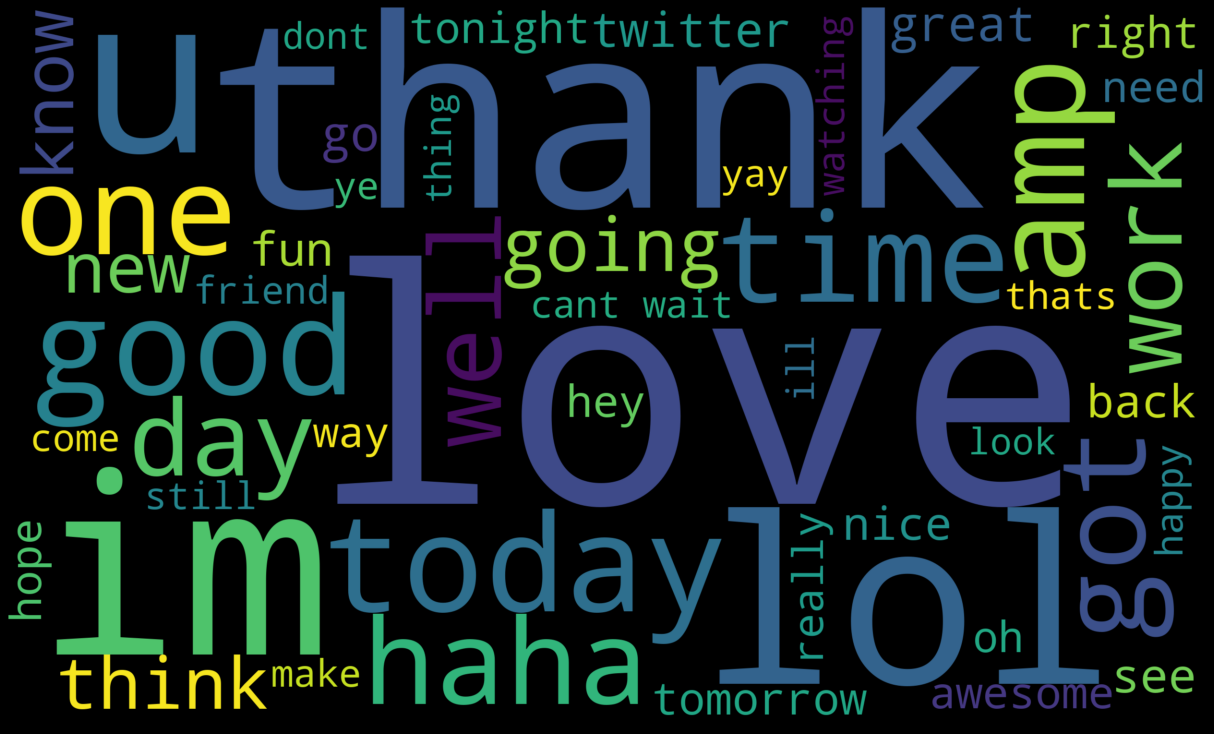

In [12]:
#plot wordcloud object
fig = plt.figure(
figsize = (20, 10),
facecolor = 'k',
edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Question 2: Generate word cloud for negative sentiment.

In [13]:
print('\n\n Count of negative: {}'.format(len(df['sentiment_label']) - np.sum(df['sentiment_label'])))



 Count of negative: 80000


In [14]:
# join entire clean_tweet column
neg_clean_string = ','.join(df.loc[df['sentiment_label'] == 0, :]['clean_tweet'])

In [15]:
# create wordcloud object
wordcloud_neg = WordCloud(
max_words=50,
width = 2500,
height = 1500,
background_color = 'black',
stopwords = STOPWORDS).generate(neg_clean_string)

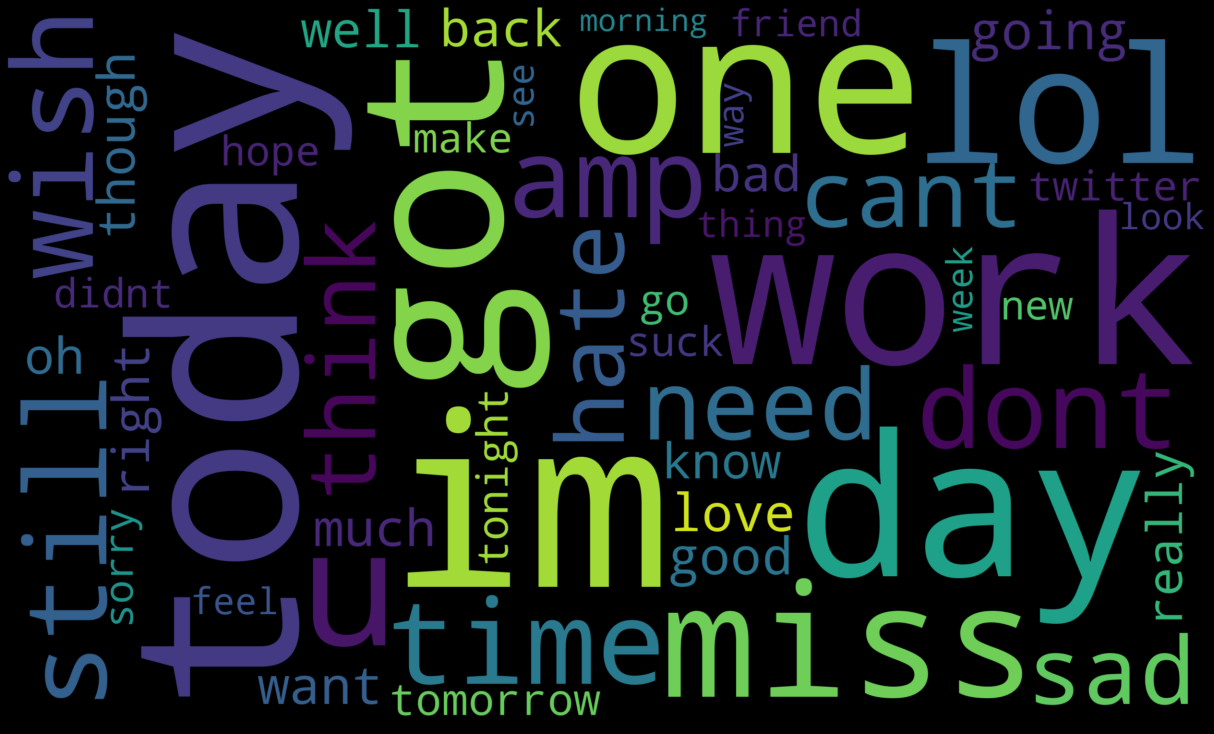

In [16]:
# plot wordcloud object
fig = plt.figure(
figsize = (20, 10),
facecolor = 'k',
edgecolor = 'k')
plt.imshow(wordcloud_neg, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Question 3: Split data where test size = 40000, random_state = 42. Max_df=0.5, max_features = 6228,

In [17]:
# Declare the TFIDF vectorizer.
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, max_features=6228, stop_words='english')# Fit the vectorizer over the dataset

clean_texts = df['clean_tweet']
tf_idf_tweets = vectorizer.fit_transform(clean_texts)
y_targets = np.array(df['sentiment_label'])

In [18]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(tf_idf_tweets, 
                                                    y_targets, 
                                                    test_size=40000,
                                                    random_state=42)

## Question 4: Build a classifier that classifies the sentiment of a sentence. Criteria - loss = modified_huber, learning_rate = adaptive, peanlty = elasticnet, set an alpha and eta as well.

In [19]:
model = SGDClassifier(loss = 'modified_huber',
                       penalty = 'elasticnet',
                       alpha = 0.0001,
                       l1_ratio = 0.15,
                       learning_rate = 'adaptive',
                       eta0 = 0.0015)

model.fit(X_train, y_train)

SGDClassifier(eta0=0.0015, learning_rate='adaptive', loss='modified_huber',
              penalty='elasticnet')

## Question 5: What is the accuracy of your model when applied to testing data?

In [20]:
## Compute results on the train and test set
train_probs = model.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = model.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

# Compute accuracies
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)

# Get the parts of the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

# Print results
print('')
print('Confusion Matrix For Test Data')
print(confusion_matrix(y_test, test_results))
print('')
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

Train accuracy: 0.7720583333333333
Test accuracy: 0.756

Confusion Matrix For Test Data
[[14422  5634]
 [ 4126 15818]]

             Class 1   -   Class 0
Precision: [0.77755014 0.73736715]
Recall   : [0.71908656 0.79312074]
F1       : [0.74717646 0.76422843]
Support  : [20056 19944]


## Question 6: What conclusions can you draw from the model?

Our model appears to perform decently, but not great and is better at predicting negative senti-
ment than it does positive sentiment. Our model could be better at predicting positive sentiment
because it more often predict positive sentiment than negative.

Some other conclusions from this analysis are:

- It is possible identify words or combination of words that when they appear together a sentiment can be infer (positive or negative).

- This has great applications in different fields where a binary direction is needed (positive or negative) to make decisions.

    - As explained before one example of this application is the stock market. Usually the media will react immediately after an event (this event can be positive or negative) and usually that has a direct impact on the price of the stocks. Therefore a quick reaction to that is needed and this is where Sentiment Analysis might be a practical solution to a binary question: buy or sell?

## [Bonus] Question 7: If you are to build a sentiment analysis model, would it be dependent on the source of data?

**Yes, the use of words is highly contextual and therefore if the source data changes even if the words are pretty similar, they could have been used in a very different way and therefore yield a different result as they express different sentiments.**

## Question 8: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: 
- What was your incoming experience with this model, if any? 
- what steps you took, what obstacles you encountered?
- how you link this exercise to real-world, machine learning problem-solving?
- What steps were missing? 
- What else do you need to learn?

Natural Language Processing is a key part of the Machine Learning Toolkit needed to make sense of data as the majority of data available comes in the shape of unstructured language data (conversations, tweets, articles, emails, etc.). As discussed in class NLP is a branch of AI that deals with analyzing, understanding and generating the languages that humans use naturally in order to interface with computers in written and spoken form.

There are many applications of this branch of AI, such as: translation, web search, spam filters, sentiment analysis, chatbots, among others. The it is possible to notice the importance of this area not only at the cutting age of the academia setting but also in our day-to-day life.

I do not work regularly with Natural Language Processing, so this assignment was a great introduction to this kind of algorithms. One of the key aspects of working on this assignment on Natural Language Processing is the importance of the steps to prepare the data for the Machine Learning model. This includes segmentation, tokenizing, looking for stop words, stemming, lemmatization, etc. This steps are critical to ensure a good performance on the model.

As a next step it would be great to compare the use of different methods for the categorization of the body of the document and the results they yield, in particular Bag of Words (BOW) Vs TF-IDF.
